In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


In [4]:
# Load dataset
data = pd.read_csv('/content/Train.csv')

# Step 1: Basic EDA
print(data.head())
print(f"Shape of the dataset: {data.shape}")
print(f"Columns in the dataset: {data.columns.tolist()}")
print(data.info())
print(data.describe())

# Step 2: Analyze categorical columns and target column
def analyze_column(col):
    print(f"\nUnique values in '{col}':")
    print(data[col].value_counts())

analyze_column('Crop')
analyze_column('category')

# Step 3: Encode target column (multi-class classification)
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])
print("Encoded target classes:", dict(zip(le.classes_, le.transform(le.classes_))))

# Step 4: Date processing
data['SDate'] = pd.to_datetime(data['SDate'])
data['HDate'] = pd.to_datetime(data['HDate'])
data['Duration'] = (data['HDate'] - data['SDate']).dt.days
data['SDate_month'] = data['SDate'].dt.month
data['HDate_month'] = data['HDate'].dt.month
data.drop(['SDate', 'HDate'], axis=1, inplace=True)

# Step 5: Handle missing values
numerical_columns = ['CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield', 'Duration']
missing_values = data.isnull().sum()
print("\nMissing values:")
print(missing_values)
for col in missing_values[missing_values > 0].index:
    if col in numerical_columns:
        data[col].fillna(data[col].mean(), inplace=True)  # Impute numerical columns with mean
    else:
        data[col].fillna(data[col].mode()[0], inplace=True)  # Impute categorical columns with mode


    FarmID  category   Crop      State District Sub-District       SDate  \
0  1326576   Healthy  Paddy  Telangana    Medak    Kulcharam  25-11-2023   
1  1326577   Healthy  Paddy  Telangana    Medak    Kulcharam  13-11-2023   
2  1326578   Healthy  Paddy  Telangana    Medak    Kulcharam  19-12-2023   
3  1331836  Diseased  Paddy  Telangana    Medak    Kulcharam  11-02-2023   
4  1326579  Diseased  Paddy  Telangana    Medak    Kulcharam  12-12-2023   

        HDate  CropCoveredArea  CHeight CNext   CLast PlantingMethod IrriType  \
0  14-04-2024               97       54   Pea  Lentil  Transplanting    Flood   
1  26-04-2024               82       58   Pea  Lentil  Transplanting    Flood   
2  28-04-2024               92       91   Pea  Lentil  Transplanting    Flood   
3  04-11-2024               91       52   Pea  Lentil  Transplanting    Flood   
4  19-05-2024               94       55   Pea  Lentil  Transplanting    Flood   

    IrriSource  IrriCount  WaterCov  ExpYield Season  \


<ipython-input-4-4ac76e8486a3>:25: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['SDate'] = pd.to_datetime(data['SDate'])
<ipython-input-4-4ac76e8486a3>:26: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['HDate'] = pd.to_datetime(data['HDate'])


Number of duplicate rows: 0


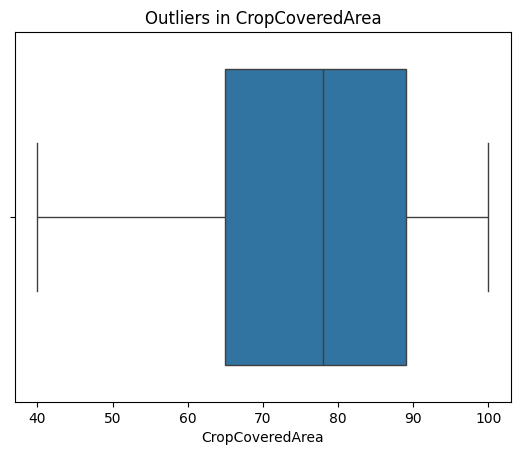

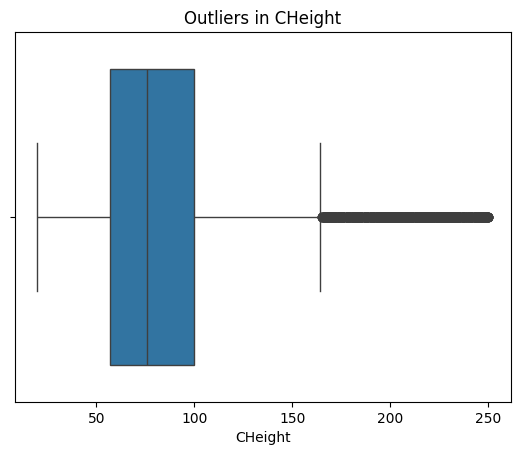

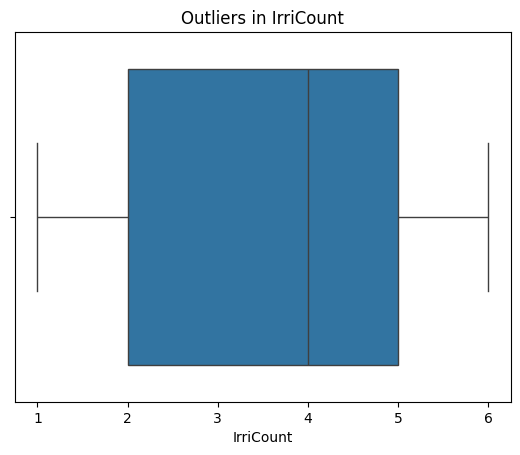

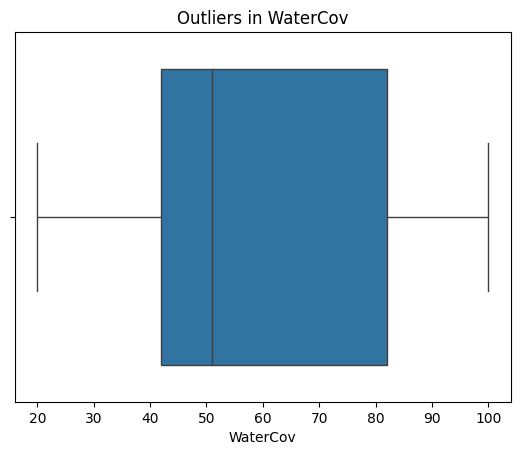

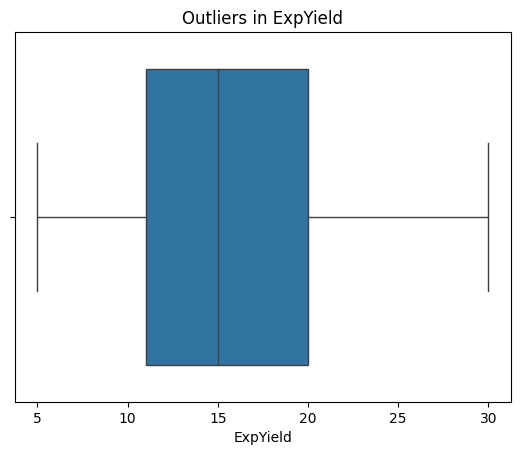

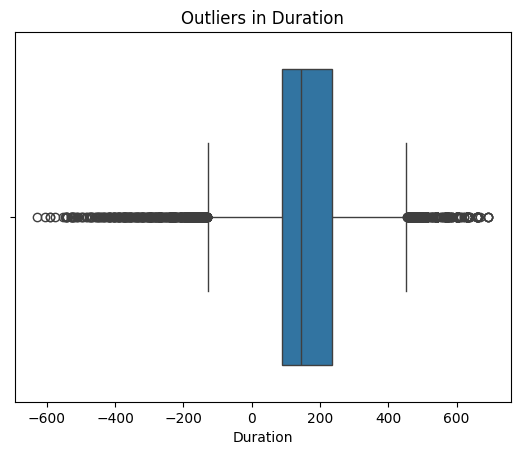

Capped 0 outliers in CropCoveredArea
Capped 888 outliers in CHeight
Capped 0 outliers in IrriCount
Capped 0 outliers in WaterCov
Capped 0 outliers in ExpYield
Capped 725 outliers in Duration
Columns in the dataset: ['category', 'Crop', 'State', 'CropCoveredArea', 'CHeight', 'CLast', 'PlantingMethod', 'IrriType', 'IrriSource', 'IrriCount', 'WaterCov', 'ExpYield', 'Season', 'Duration', 'SDate_month', 'HDate_month']


In [5]:
# Step 6: Detect and remove duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
data.drop_duplicates(inplace=True)

# Step 7: Analyze and handle outliers
for col in numerical_columns:
    sns.boxplot(x=data[col])
    plt.title(f'Outliers in {col}')
    plt.show()

for col in numerical_columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    capped_count = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
    print(f"Capped {capped_count} outliers in {col}")
    data[col] = np.clip(data[col], lower_bound, upper_bound)

# Step 8: Rename columns
data.rename(columns={'CTransp': 'PlantingMethod'}, inplace=True)

# Step 9: Drop irrelevant columns
data = data.drop([ 'District', 'Sub-District',
                   'FarmID', 'CNext', 'geometry'], axis=1)
print(f"Columns in the dataset: {data.columns.tolist()}")

In [6]:
# Step 10: Target encoding for categorical columns

columns_to_encode = data.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the remaining categorical columns
data_encoded = pd.get_dummies(data, columns=columns_to_encode)

print(data_encoded.head())

for col in columns_to_encode:
    print(f"{col}: {data[col].nunique()} unique values")

bool_columns = data_encoded.select_dtypes(include=[bool]).columns

# Identify the boolean columns (those that are True/False) in the encoded data
bool_columns = data_encoded.select_dtypes(include=[bool]).columns

# Convert the boolean columns to integers (1 for True, 0 for False)
data_encoded[bool_columns] = data_encoded[bool_columns].astype(int)

# Verify the changes
print(data_encoded.head())

# Save the updated, not encoded, dataset to a new CSV file
data.to_csv('Train_processed.csv', index=False)

df = data_encoded
print(df.shape)

   category  CropCoveredArea  CHeight  IrriCount  WaterCov  ExpYield  \
0         1               97     54.0          4        87        17   
1         1               82     58.0          5        94        15   
2         1               92     91.0          3        99        20   
3         0               91     52.0          5        92        16   
4         0               94     55.0          5        97        20   

   Duration  SDate_month  HDate_month  Crop_Bengal Gram  ...  IrriType_Flood  \
0       141           11            4             False  ...            True   
1       165           11            4             False  ...            True   
2       131           12            4             False  ...            True   
3       455            2           11             False  ...            True   
4       159           12            5             False  ...            True   

   IrriType_Sprinkler  IrriType_Surface  IrriSource_Canal  \
0               False    

Mutual Information Scores:
CHeight                         0.012029
PlantingMethod_Transplanting    0.007314
CLast_Soybean                   0.006075
ExpYield                        0.005724
PlantingMethod_Seed Drilling    0.005350
IrriSource_Groundwater          0.005325
WaterCov                        0.005225
PlantingMethod_Broadcasting     0.004764
CropCoveredArea                 0.004540
Crop_Chillies                   0.004469
State_Telangana                 0.004177
CLast_Sorghum                   0.003483
Crop_Paddy                      0.003056
Duration                        0.002939
HDate_month                     0.002663
CLast_Tomato                    0.002552
SDate_month                     0.001871
Crop_Bengal Gram                0.001720
Crop_Maize                      0.000858
Season_Rabi                     0.000751
IrriSource_Rainfed              0.000434
Crop_Cotton                     0.000121
CLast_Onion                     0.000000
IrriType_Flood                

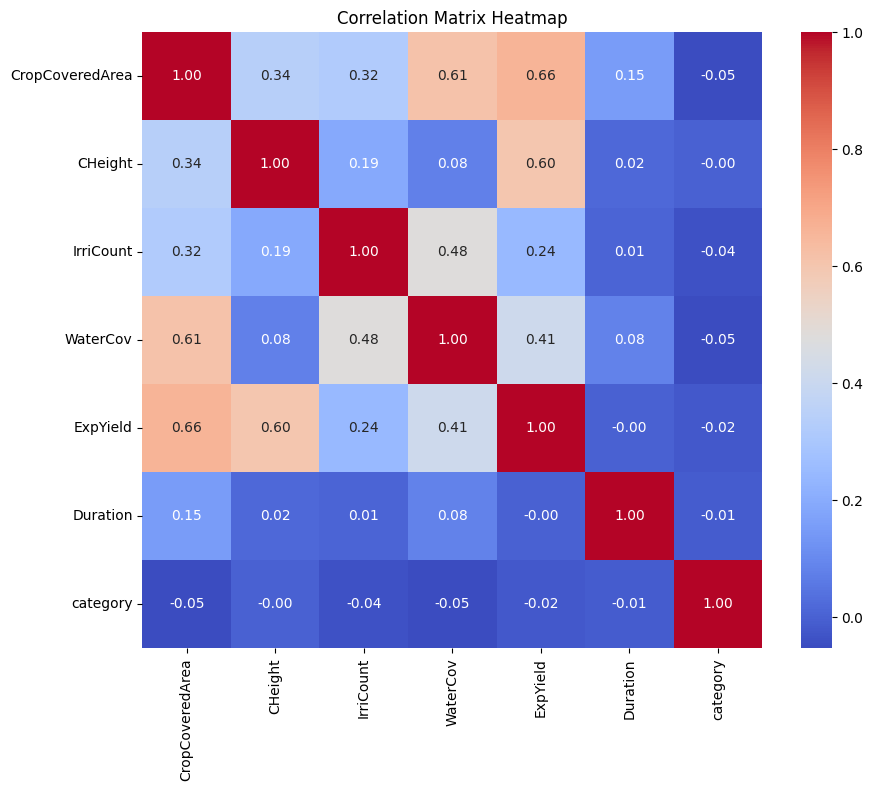

Selected Features by RFE: ['CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield', 'Duration', 'SDate_month', 'HDate_month', 'Crop_Cotton', 'Crop_Maize', 'CLast_Lentil', 'CLast_Maize', 'CLast_Mustard', 'CLast_Onion', 'CLast_Pea', 'CLast_Sorghum', 'CLast_Soybean', 'CLast_Tomato', 'CLast_Wheat', 'PlantingMethod_Broadcasting', 'PlantingMethod_Drilling', 'PlantingMethod_Seed Drilling', 'IrriType_Drip', 'IrriType_Sprinkler', 'IrriType_Surface', 'IrriSource_Canal', 'IrriSource_Groundwater', 'IrriSource_Rainfed', 'Season_Kharif', 'Season_Rabi']
Index(['IrriSource_Tubewell', 'PlantingMethod_Transplanting', 'Crop_Maize',
       'CLast_Onion', 'IrriType_Flood', 'SDate_month', 'WaterCov',
       'PlantingMethod_Seed Drilling', 'PlantingMethod_Broadcasting',
       'CLast_Sorghum', 'Crop_Cotton', 'PlantingMethod_Drilling', 'CHeight',
       'IrriSource_Well', 'ExpYield', 'IrriType_Sprinkler', 'Crop_Bengal Gram',
       'CLast_Maize', 'CLast_Lentil', 'CLast_Tomato', 'IrriType_Surface',
 

In [9]:
# Step 11: Feature selection
X = df.drop(columns=['category'])
y = df['category']

# Mutual Information
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:")
print(mi_scores)

# Correlation analysis
correlation_matrix = df[numerical_columns + ['category']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

# Recursive Feature Elimination
model = RandomForestClassifier(random_state=42)
rfe = RFE(model, n_features_to_select=30)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", selected_features.tolist())

# Final feature set
final_features = list(set(selected_features) | set(mi_scores.head(30).index))
X = X[final_features]
print(X.columns, "\n")

In [10]:
# Step 12: Train-validation split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


print("Columns in X_val:", X_val.columns)



# Step 14: Scale features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


Columns in X_val: Index(['IrriSource_Tubewell', 'PlantingMethod_Transplanting', 'Crop_Maize',
       'CLast_Onion', 'IrriType_Flood', 'SDate_month', 'WaterCov',
       'PlantingMethod_Seed Drilling', 'PlantingMethod_Broadcasting',
       'CLast_Sorghum', 'Crop_Cotton', 'PlantingMethod_Drilling', 'CHeight',
       'IrriSource_Well', 'ExpYield', 'IrriType_Sprinkler', 'Crop_Bengal Gram',
       'CLast_Maize', 'CLast_Lentil', 'CLast_Tomato', 'IrriType_Surface',
       'IrriSource_Rainfed', 'Crop_Paddy', 'CLast_Pea', 'Duration',
       'IrriCount', 'CropCoveredArea', 'CLast_Wheat', 'IrriSource_Groundwater',
       'Season_Kharif', 'CLast_Soybean', 'Crop_Chillies', 'HDate_month',
       'CLast_Mustard', 'IrriType_Drip', 'IrriSource_Canal', 'State_Telangana',
       'Season_Rabi'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


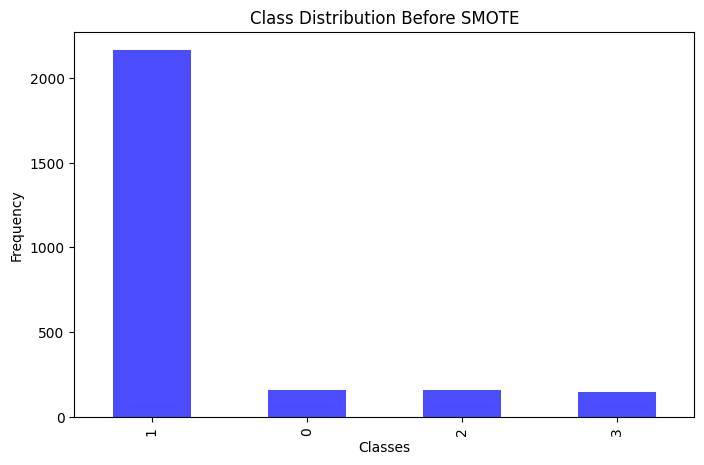

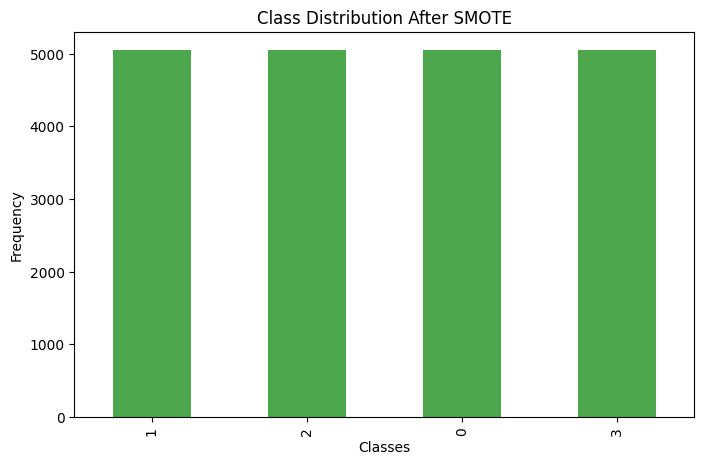

In [11]:
# Step 13: Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Visualize Class Distribution Before and After SMOTE
plt.figure(figsize=(8, 5))
y_train_original = y_temp[y_temp.index.isin(X_train.index)]  # Original y_train before SMOTE
y_train_original.value_counts().plot(kind='bar', color='blue', alpha=0.7)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
pd.Series(y_train).value_counts().plot(kind='bar', color='green', alpha=0.7)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()

In [12]:
# Step 14: Scale features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [14]:
X_train['category'] = y_train
X_val['category'] = y_val
X_test['category'] = y_test

X_train.to_csv('processed_train.csv', index=False)
X_val.to_csv('processed_val.csv', index=False)
X_test.to_csv('processed_test.csv', index=False)